In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [4]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data

training_data = process_data.load_data(interpolated_dir, 
                                       years = [2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win"
                                       )

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = True
                                       )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127989.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127963.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127963.csv
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fix

In [5]:
training_data.keys()

dict_keys([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2, 0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.285, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47, 0.475, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.565, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 0.625, 0.63, 0.635, 0.64, 0.645, 0.65, 0.655, 0.66, 0.665, 0.67, 0.675, 0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72, 0.725, 0.73, 0.735, 0.74, 0.745, 0.75, 0.755, 0.76, 0.7

In [25]:
modules_to_reload = [
    'models.xg_boost',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data

from models.xg_boost import setup_xgboost_models
other_features = [
            "type.id",             # Play type (categorical)
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
    "field_position_shift"
]
models = setup_xgboost_models(training_data, validation_data, numeric_features = numeric_features, other_features = other_features, all_features = features, optimize_hyperparams=False, use_calibration=True)


Timestep 0.00%(Calibrated): Training Loss = 0.3666, Accuracy = 0.6334, Validation Loss = 0.2179, Validation Accuracy = 0.6464
Timestep 0.50%(Calibrated): Training Loss = 0.3670, Accuracy = 0.6330, Validation Loss = 0.2256, Validation Accuracy = 0.6210
Timestep 1.00%(Calibrated): Training Loss = 0.3555, Accuracy = 0.6445, Validation Loss = 0.2174, Validation Accuracy = 0.6391
Timestep 1.50%(Calibrated): Training Loss = 0.3509, Accuracy = 0.6491, Validation Loss = 0.2224, Validation Accuracy = 0.6250
Timestep 2.00%(Calibrated): Training Loss = 0.3750, Accuracy = 0.6250, Validation Loss = 0.2343, Validation Accuracy = 0.5848
Timestep 2.50%(Calibrated): Training Loss = 0.3641, Accuracy = 0.6359, Validation Loss = 0.2109, Validation Accuracy = 0.6519
Timestep 3.00%(Calibrated): Training Loss = 0.3156, Accuracy = 0.6844, Validation Loss = 0.2148, Validation Accuracy = 0.6336
Timestep 3.50%(Calibrated): Training Loss = 0.3498, Accuracy = 0.6502, Validation Loss = 0.2271, Validation Accuracy =

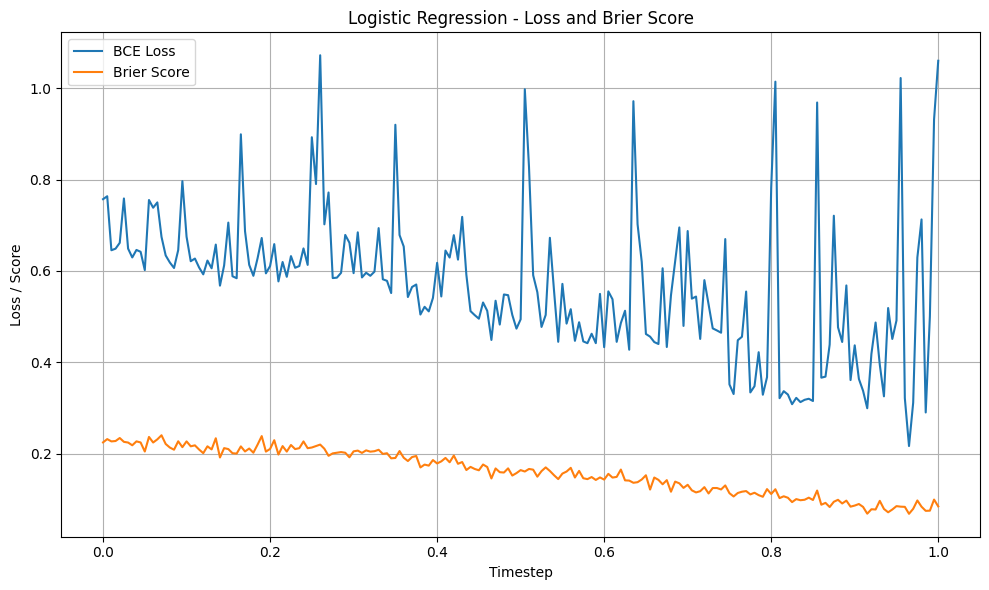

In [32]:
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PermutationExplainer explainer: 365it [01:37,  3.53it/s]                         


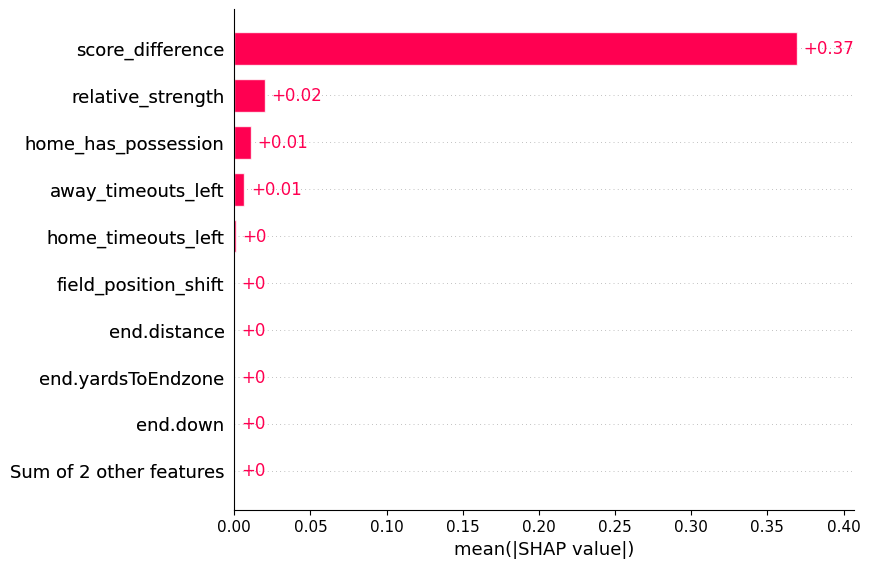

.values =
array([[ 0.00000000e+00, -1.22129159e-02, -4.92307711e-01, ...,
         0.00000000e+00, -1.68647938e-04, -6.81755968e-03],
       [ 0.00000000e+00, -2.60015388e-03,  4.80419578e-01, ...,
         0.00000000e+00,  6.77254229e-04,  1.27527466e-03],
       [ 0.00000000e+00, -2.23154646e-03,  4.80037471e-01, ...,
         0.00000000e+00,  8.12403447e-04,  1.53783105e-03],
       ...,
       [ 0.00000000e+00, -1.21440163e-02,  8.53030489e-03, ...,
         0.00000000e+00, -1.37927339e-04, -8.12306150e-03],
       [ 0.00000000e+00, -3.36966898e-02,  3.48296460e-01, ...,
         0.00000000e+00, -6.95559048e-03,  1.26768164e-02],
       [ 0.00000000e+00,  9.04817808e-02,  3.94136603e-01, ...,
         0.00000000e+00, -6.10337648e-04,  8.71646721e-03]])

.base_values =
array([0.51460955, 0.51460955, 0.51460955, 0.51460955, 0.51460955,
       0.51460955, 0.51460955, 0.51460955, 0.51460955, 0.51460955,
       0.51460955, 0.51460955, 0.51460955, 0.51460955, 0.51460955,
       0.5146095

In [ ]:
%reload_ext autoreload
from models.utils import SHAP_analysis


SHAP_analysis(models, 0.95, training_data, test_data)

In [30]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from process_data import write_predictions

write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "xgboost_phat_b_model")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces